In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision

import h5py
import os

from CNNModels import *
from CNNTrain import *

In [2]:
np.random.seed(0) # set seed for reproduceability

In [3]:
with h5py.File("/mnt/gs18/scratch/users/tranant2/Test/data_0.hdf5", 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['00_entry', '01_drift', '02_drift', '03_mhb4', '04_scrch', '05_drift', '06_eq3d', '07_eq3d', '08_drift', '09_eq3d', '10_eq3d', '11_drift', '12_eq3d', '13_eq3d', '14_drift', '15_eq3d', '16_eq3d', '17_eq3d', '18_drift', 'Input']>


In [4]:
class H5Dataset(torch.utils.data.Dataset):
    # Given a list of h5_path files, extract the voltage, distribution, and loss values
    def __init__(self, h5_paths, transform=False, size = 94):
        self.h5_paths = h5_paths
        self.transform=transform
        self.size = size
        # Code to get data from hdf5 files and put into memory
        i=0
        self.voltages, distro, output= self.extract_data(h5_paths[i])
        self.distro_0 = distro[0]
        self.distro_1 = distro[1]
        self.distro_2 = distro[2]
        self.distro_3 = distro[3]
        self.distro_4 = distro[4]
        self.output_0 = output[0]
        self.output_1 = output[1]
        self.output_2 = output[2]
        self.output_3 = output[3]
        i+=1
        while(i<len(h5_paths)):
            if h5_paths[1].endswith('.hdf5'):
                a, b, c = self.extract_data(h5_paths[i])
                self.voltages = np.concatenate((self.voltages,a))
                self.distro_0 = np.concatenate((self.distro_0,b[0]))
                self.distro_1 = np.concatenate((self.distro_1,b[1]))
                self.distro_2 = np.concatenate((self.distro_2,b[2]))
                self.distro_3 = np.concatenate((self.distro_3,b[3]))
                self.distro_4 = np.concatenate((self.distro_4,b[4]))
                self.output_0 = np.concatenate((self.output_0,c[0]))
                self.output_1 = np.concatenate((self.output_1,c[1]))
                self.output_2 = np.concatenate((self.output_2,c[2]))
                self.output_3 = np.concatenate((self.output_3,c[3]))
            i+=1
        # Make sure all particles that starts are inside the aperature
        distro_sum = self.distro_0.sum(axis=(1,2,3))
        mask = distro_sum>60000
        self.voltages = self.voltages[mask]
        self.distro_0 = self.distro_0[mask]
        self.distro_1 = self.distro_1[mask]
        self.distro_2 = self.distro_2[mask]
        self.distro_3 = self.distro_3[mask]
        self.distro_4 = self.distro_4[mask]
        self.output_0 = self.output_0[mask]
        self.output_1 = self.output_1[mask]
        self.output_2 = self.output_2[mask]
        self.output_3 = self.output_3[mask]
        # normalizing the data from [-1,1]
        self.voltages = self.voltages/8
        self.len = len(self.output_0)
        
        self.resize = torchvision.transforms.Resize((self.size,self.size))

    def __getitem__(self, index):
        if (self.transform):
            return ((self.voltages[index],  # voltages on quad
                     self.Resize(self.distro_0[index]),  # Distribution images
                     self.Resize(self.distro_1[index]),
                     self.Resize(self.distro_2[index]),
                     self.Resize(self.distro_3[index]),
                     self.Resize(self.distro_4[index])),
                    (self.output_0[index],  # outputs
                     self.output_1[index],
                     self.output_2[index],
                     self.output_3[index]))
        else:
            return ((self.voltages[index],  # voltages on quad
                     self.distro_0[index],  # Distribution images
                     self.distro_1[index],
                     self.distro_2[index],
                     self.distro_3[index],
                     self.distro_4[index]),
                    (self.output_0[index],  # outputs
                     self.output_1[index],
                     self.output_2[index],
                     self.output_3[index]))

    def __len__(self):
        return self.len
    
    def Resize(self, data):
        s = np.array(data).shape
        tempdata = torch.zeros((self.size, self.size, s[-1]))
        for i in range(s[-1]):
            tempdata[:,:,i] = self.resize(torch.from_numpy(data[:,:,i]).squeeze().unsqueeze(dim=0))
        return np.array(tempdata)
    
    def get_memory(self):
        """
        Return memory in GBs
        """
        memory = self.voltages.nbytes
        memory += self.distro_0.nbytes
        memory += self.distro_1.nbytes
        memory += self.distro_2.nbytes
        memory += self.distro_3.nbytes
        memory += self.distro_4.nbytes
        memory += self.output_0.nbytes
        memory += self.output_1.nbytes
        memory += self.output_2.nbytes
        memory += self.output_3.nbytes # float32 has 4 byte
        memory = memory/1028**3
        return memory
    
    def extract_data(self, file):
        with h5py.File(file, 'r') as f:
            v = pd.DataFrame(f['Input/v1'])
            nonzero = (v.shape[0]-(v==0).sum())[0]  # Get number of nonzero values from file
            print(nonzero)
            v1 = f['Input/v1'][:nonzero]
            v2 = f['Input/v2'][:nonzero]
            v3 = f['Input/v3'][:nonzero]
            v4 = f['Input/v4'][:nonzero]
            v5 = f['Input/v5'][:nonzero]
            v6 = f['Input/v6'][:nonzero]
            v = pd.DataFrame([v1,v2,v3,v4,v5,v6]).T  # This creates a vector of voltage data

            exit_left = [None]*4
            exit_left[0] = f['08_drift/#of_part_left'][:nonzero]  #Get number of particles after first quad pair
            exit_left[1] = f['11_drift/#of_part_left'][:nonzero]  #Get number of particles after second quad pair
            exit_left[2] = f['14_drift/#of_part_left'][:nonzero]  #Get number of particles after third quad pair
            exit_left[3] = f['18_drift/#of_part_left'][:nonzero]  #Get number of particles left at the last element
            ploss_0 = pd.DataFrame(exit_left[0]) 
            ploss_1 = pd.DataFrame(exit_left[1]) 
            ploss_2 = pd.DataFrame(exit_left[2]) 
            ploss_3 = pd.DataFrame(exit_left[3]) 

            distro = [None]*5
            distro[0] = f['Input/33x33_0'][:nonzero,:,:,:]
            distro[1] = f['Input/33x33_1'][:nonzero,:,:,:]
            distro[2] = f['Input/33x33_2'][:nonzero,:,:,:]
            distro[3] = f['Input/33x33_3'][:nonzero,:,:,:]
            distro[4] = f['Input/33x33_4'][:nonzero,:,:,:]
            print(distro[0].shape)

        voltage = v.values
        distro = np.array(distro)
        loss = np.array(exit_left)
        return (voltage, distro, loss)

In [5]:
# Make a function to get data from a list of files
hdf5_dir = "/mnt/gs18/scratch/users/tranant2/Test"
files = os.listdir(hdf5_dir)
hdf5_files1 = [(hdf5_dir + '/'+i) for i in files ]
hdf5_files1

['/mnt/gs18/scratch/users/tranant2/Test/data_0.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_9.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_28.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_22.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_2.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_29.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_27.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_4.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_3.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_31.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_13.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_24.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_30.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_21.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_7.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_26.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_6.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_17.hdf5',
 '/mnt/gs18/scrat

In [6]:
dataset = H5Dataset(hdf5_files1, transform=False)

256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)


In [7]:
test_loader = DataLoader(dataset=dataset, batch_size = 1024, shuffle=True)

## Make sure GPU is avaliable

In [8]:
print(f"Is GPU avaliable: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Got the: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/(1028**3)} GB")

Is GPU avaliable: True
Got the: Tesla K80
Total memory: 11.781983108519892 GB


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Computation will be happening on the {device}")

Computation will be happening on the cuda:0


## Set up Model

In [10]:
model = VAE().to(device)

In [11]:
model.load_state_dict(torch.load( f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model__1.pth"), strict=False)

<All keys matched successfully>

In [12]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

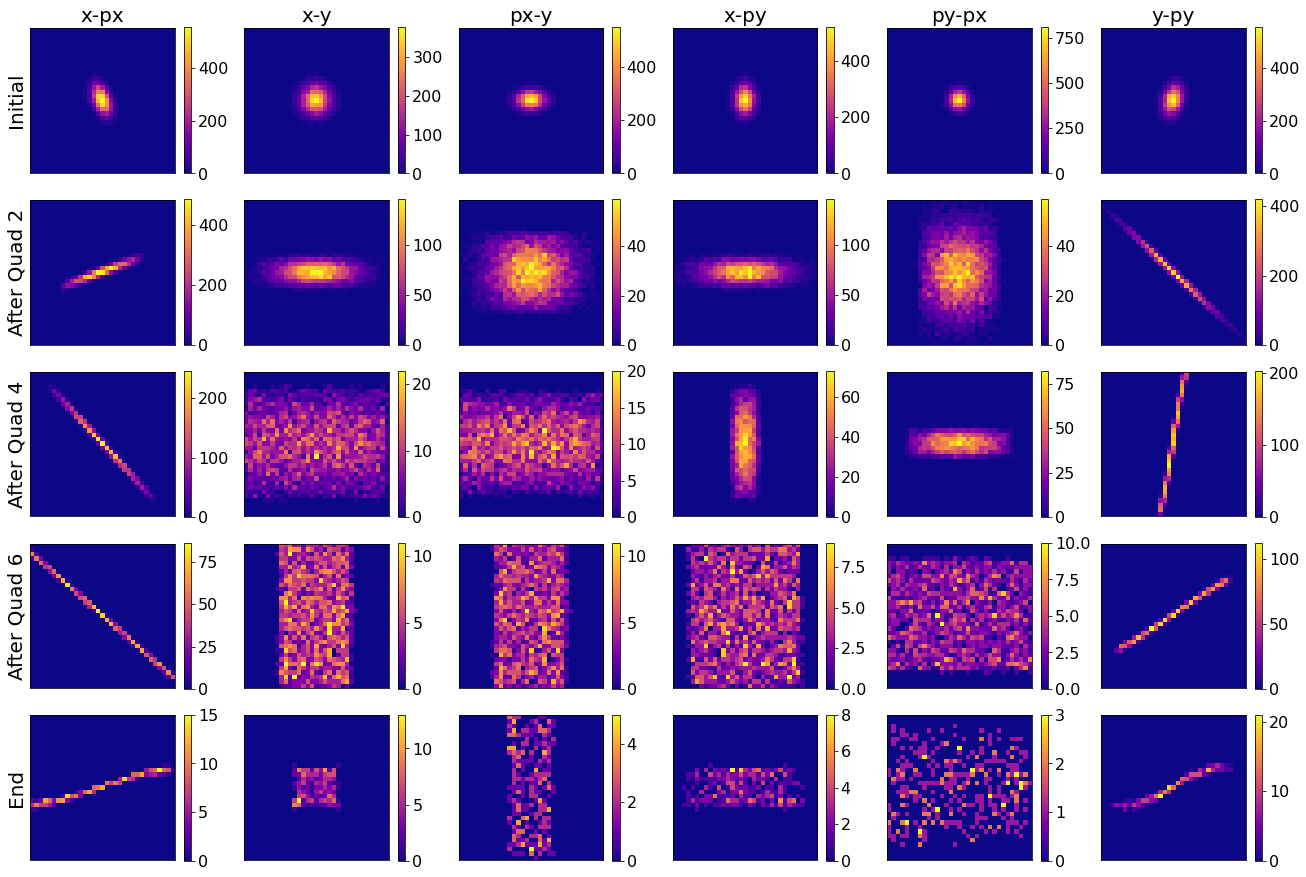

In [13]:
fig, ax = plt.subplots(5,6,figsize=(18,12))
nimg = 5
for j in range(5):
    for i in range(6):
        pc = ax[j,i].imshow(np.array(test_data[j+1])[nimg,:,:,i],
                            cmap='plasma',
                            interpolation='none',
                           aspect='equal')
        cbar = fig.colorbar(pc, ax=ax[j, i])
        cbar.ax.tick_params(labelsize=16)
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([], fontsize=14)
plt.tight_layout()

ax[0,0].set_title("x-px", fontsize=20)
ax[0,1].set_title("x-y", fontsize=20)
ax[0,2].set_title("px-y", fontsize=20)
ax[0,3].set_title("x-py", fontsize=20)
ax[0,4].set_title("py-px", fontsize=20)
ax[0,5].set_title("y-py", fontsize=20)

ax[0,0].set_ylabel("Initial", fontsize=20)
ax[1,0].set_ylabel("After Quad 2", fontsize=20)
ax[2,0].set_ylabel("After Quad 4", fontsize=20)
ax[3,0].set_ylabel("After Quad 6", fontsize=20)
ax[4,0].set_ylabel("End", fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/OriginalPhaseSpace_Final.png", dpi = 300, bbox_inches="tight")

In [29]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
#loss0 = nn.MSELoss()(output_0, losses[0])
#loss1 = nn.MSELoss()(output_1, losses[1])
#loss2 = nn.MSELoss()(output_2, losses[2])
#loss3 = nn.MSELoss()(output_3, losses[3])
loss4 = nn.MSELoss()(distro_0, distro[0])
loss5 = nn.MSELoss()(distro_1, distro[1])
loss6 = nn.MSELoss()(distro_2, distro[2])
loss7 = nn.MSELoss()(distro_3, distro[3])
loss8 = nn.MSELoss()(distro_4, distro[4])
print(f"loss0:{0},loss1:{0}, loss2:{0}, loss3:{0},\n distro0:{loss4}, distro1:{loss5}, distro2:{loss6}, distro3:{loss7}, distro4:{loss8}")
    


loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:4.921535968780518, distro1:8.070245742797852, distro2:9.408992767333984, distro3:11.877985954284668, distro4:4.8517022132873535


**What projections are these?**

__source code__
A=grid_deposition(n,x,px,rap,rad)
B=grid_deposition(n,x,y,rap, rap)
C=grid_deposition(n,px,y,rad,rap)
D=grid_deposition(n,x,py,rap,rad)
E=grid_deposition(n,py,px,rad,rad)
F=grid_deposition(n,y,py,rap,rad)
image = np.stack([A,B,C,D,E,F],axis=2)

rap=3 
rad=0.05 

x,px
x,y
px,y
x,py
py,px
y,py

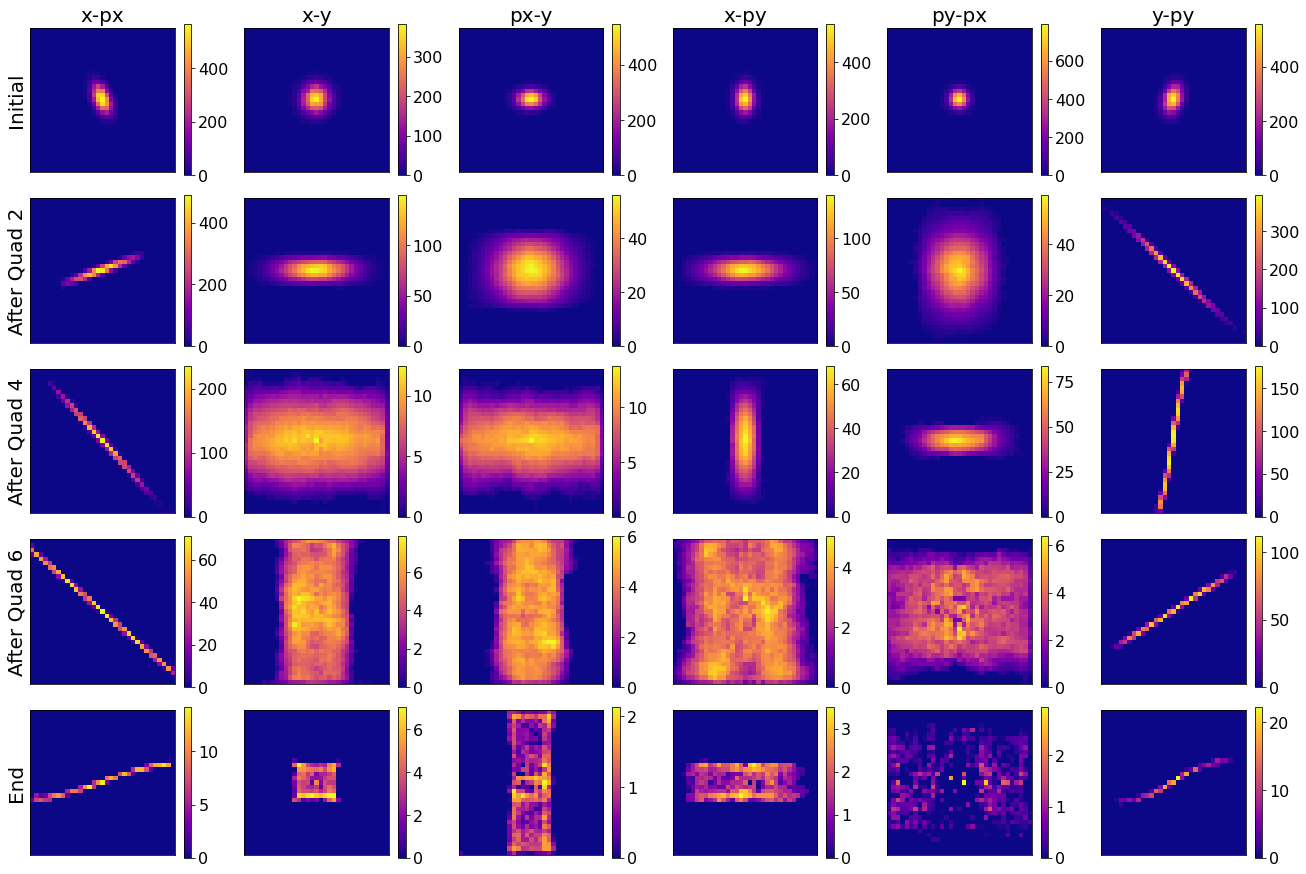

In [30]:
fig, ax = plt.subplots(5,6,figsize=(18,12))
nimg = 5
for j in range(5):
    for i in range(6):
        pc = ax[j,i].imshow(np.array(distro[j].cpu())[nimg,:,:,i],
                            cmap='plasma',
                            interpolation='none',
                           aspect='equal')
        cbar = fig.colorbar(pc, ax=ax[j, i])
        cbar.ax.tick_params(labelsize=16)
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([], fontsize=14)
plt.tight_layout()

ax[0,0].set_title("x-px", fontsize=20)
ax[0,1].set_title("x-y", fontsize=20)
ax[0,2].set_title("px-y", fontsize=20)
ax[0,3].set_title("x-py", fontsize=20)
ax[0,4].set_title("py-px", fontsize=20)
ax[0,5].set_title("y-py", fontsize=20)

ax[0,0].set_ylabel("Initial", fontsize=20)
ax[1,0].set_ylabel("After Quad 2", fontsize=20)
ax[2,0].set_ylabel("After Quad 4", fontsize=20)
ax[3,0].set_ylabel("After Quad 6", fontsize=20)
ax[4,0].set_ylabel("End", fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/ReconstructedPhaseSpace_Final.png", dpi = 300, bbox_inches="tight")

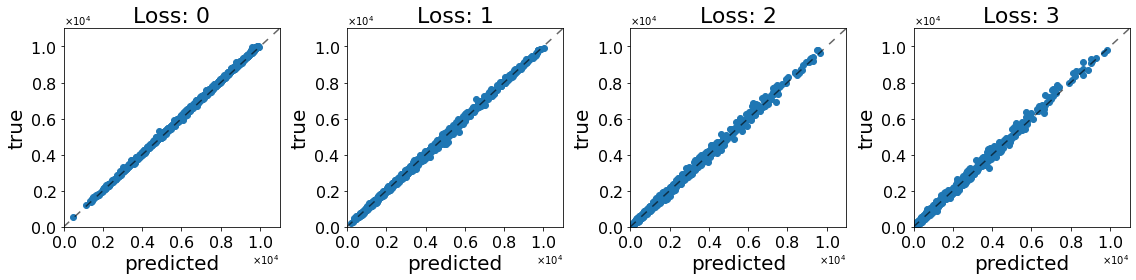

In [31]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted', fontsize=20)
    plt.ylabel('true', fontsize=20)
    plt.xlim(0,11000)
    plt.ylim(0,11000)
    plt.title(f"Loss: {i}", fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ticklabel_format(axis='both', style='scientific', useMathText=True, scilimits=(0,0))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)), alpha=.6)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Losses_Final.png", dpi = 300, bbox_inches="tight")

## Calculate error and sd

In [32]:
diff = np.zeros((4, losses[0].shape[0]))
for i in range(4):
    diff[i] = test_targets[i]-losses[i].cpu()  # If positive error, model tends to underestimate

In [33]:
for i in range(4):
    u = np.mean(diff[i])
    sd = np.std(diff[i])
    print(f"For the {i} loss location, mean:{u}. std:{sd}")

For the 0 loss location, mean:104.70287850499153. std:61.9821655576891
For the 1 loss location, mean:20.622259989380836. std:90.25740656238594
For the 2 loss location, mean:32.98197668232024. std:111.54204035919932
For the 3 loss location, mean:36.50662752613425. std:115.46793693506471


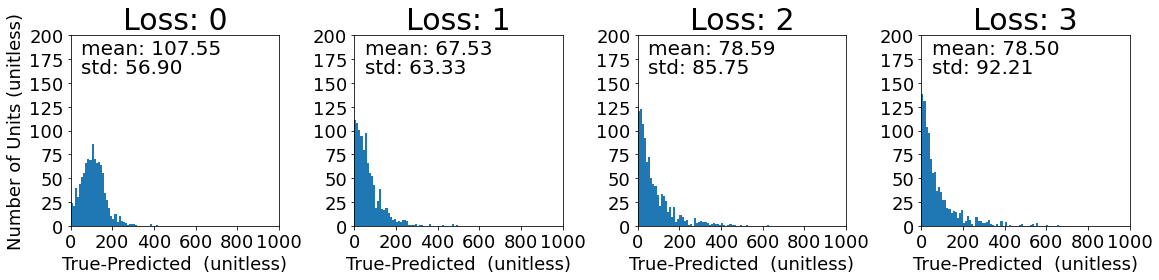

In [34]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.hist(np.abs(diff[i]), np.arange(0,1000,10))
    plt.xlabel('True-Predicted  (unitless)', fontsize=18)
    if i == 0:
        plt.ylabel('Number of Units (unitless)', fontsize=18)
    plt.title(f"Loss: {i}", fontsize=30)
    plt.xlim(0,1000)
    plt.ylim(0,200)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    u = np.mean(np.abs(diff[i]))
    sd = np.std(np.abs(diff[i]))
    plt.text(50, 180, "mean: {:.2f}".format(u), fontsize=20)
    plt.text(50, 160, "std: {:.2f}".format(sd), fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Histogram_Final0.png", dpi = 300, bbox_inches="tight")

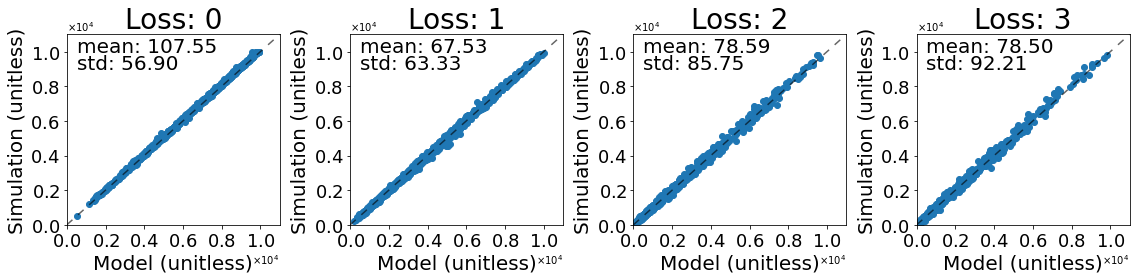

In [37]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('Model (unitless)', fontsize=20)
    plt.ylabel('Simulation (unitless)', fontsize=20)
    plt.xlim(0,11000)
    plt.ylim(0,11000)
    plt.title(f"Loss: {i}", fontsize=28)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ticklabel_format(axis='both', style='scientific', useMathText=True, scilimits=(0,0))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)), alpha=.6)
    u = np.mean(np.abs(diff[i]))
    sd = np.std(np.abs(diff[i]))
    plt.text(500, 10000, "mean: {:.2f}".format(u), fontsize=20)
    plt.text(500, 9000, "std: {:.2f}".format(sd), fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Losses_Final_6.png", dpi = 300, bbox_inches="tight")

# Finding minimum beam transmission

Given a certain initial beam distribtuion, what are the quad settings which would minimize the beam loss.

In [20]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
#loss0 = nn.MSELoss()(output_0, losses[0])
#loss1 = nn.MSELoss()(output_1, losses[1])
#loss2 = nn.MSELoss()(output_2, losses[2])
#loss3 = nn.MSELoss()(output_3, losses[3])
loss4 = nn.MSELoss()(distro_0, distro[0])
loss5 = nn.MSELoss()(distro_1, distro[1])
loss6 = nn.MSELoss()(distro_2, distro[2])
loss7 = nn.MSELoss()(distro_3, distro[3])
loss8 = nn.MSELoss()(distro_4, distro[4])
print(f"loss0:{0},loss1:{0}, loss2:{0}, loss3:{0},\n distro0:{loss4}, distro1:{loss5}, distro2:{loss6}, distro3:{loss7}, distro4:{loss8}")
    


loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:4.921535491943359, distro1:8.070245742797852, distro2:9.4089937210083, distro3:11.877985954284668, distro4:4.8517022132873535


In [21]:
voltages = test_data[0][0:2].to(device)
distro_0 = test_data[1][0:2].to(device)
distro_1 = test_data[2][0:2].to(device)
distro_2 = test_data[3][0:2].to(device)
distro_3 = test_data[4][0:2].to(device)
distro_4 = test_data[5][0:2].to(device)
output_0 = test_targets[0][0:2].to(device)
output_1 = test_targets[1][0:2].to(device)
output_2 = test_targets[2][0:2].to(device)
output_3 = test_targets[3][0:2].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)

In [22]:
voltages = torch.tensor([[ 1.03619565, -1.0908271,   0.9911924,  -0.79512005 , 1.0546695 , -0.9936274 ],
              [ 3.22001237, -2.45706761,  5.99996218, -3.44815908,  5.99998552, -3.31182581]], device=device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
print(losses)

[tensor([ 9700.4277, 13372.0020], device='cuda:0'), tensor([10048.1729,  6806.5796], device='cuda:0'), tensor([10018.1152, 11558.8682], device='cuda:0'), tensor([10363.1611, 14542.0068], device='cuda:0')]


In [23]:
from scipy.optimize import minimize

In [24]:
def ATLAS(x):
    """The ATLAS function"""
    voltages[0] = torch.tensor(x, device=device)
    with torch.no_grad():
        distro, losses = model(voltages=voltages,
                               distro0=distro_0,
                               distro1=distro_1,
                               distro2=distro_2,
                               distro3=distro_3,
                               distro4=distro_4,
                               output0=output_0,
                               output1=output_1,
                               output2=output_2,
                               output3=output_3)
    return -np.array(losses[3][0].cpu())

In [25]:
x0 = np.array([ 1, -1,  1, -1,  1, -1])
res = minimize(ATLAS, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True},
              bounds=[(0,6),(-6,0),(0,6),(-6,0),(0,6),(-6,0)])

Optimization terminated successfully.
         Current function value: -11528.868164
         Iterations: 454
         Function evaluations: 808


In [26]:
print(res.x)

[ 1.04586819 -1.12984501  0.9169441  -0.56197045  1.66972513 -1.39884498]


Text(160.31960591133, 0.5, 'End')

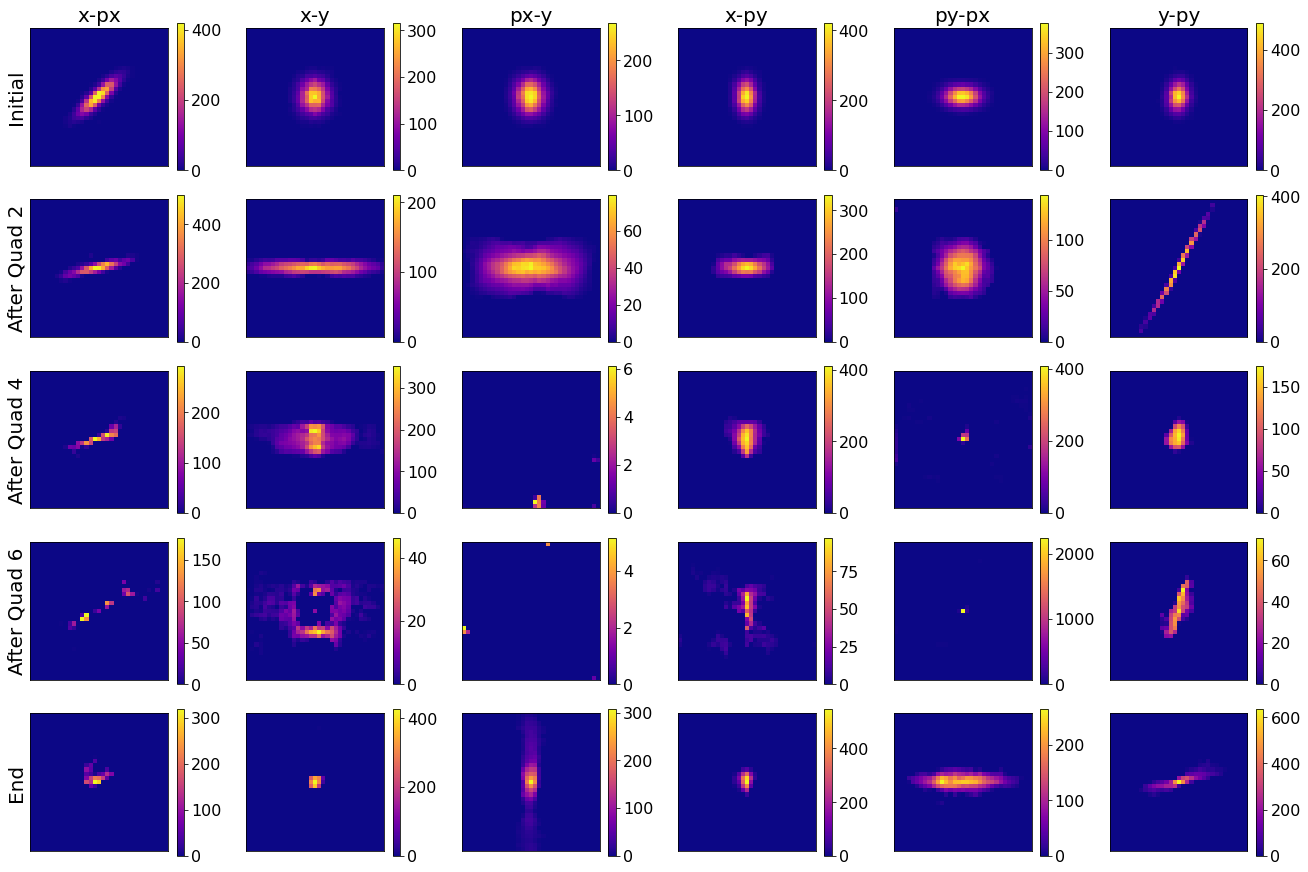

In [27]:
fig, ax = plt.subplots(5,6,figsize=(18,12))
nimg = 1
for j in range(5):
    for i in range(6):
        pc = ax[j,i].imshow(np.array(distro[j].cpu())[nimg,:,:,i],
                            cmap='plasma',
                            interpolation='none',
                           aspect='equal')
        cbar = fig.colorbar(pc, ax=ax[j, i])
        cbar.ax.tick_params(labelsize=16)
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([], fontsize=14)
plt.tight_layout()

ax[0,0].set_title("x-px", fontsize=20)
ax[0,1].set_title("x-y", fontsize=20)
ax[0,2].set_title("px-y", fontsize=20)
ax[0,3].set_title("x-py", fontsize=20)
ax[0,4].set_title("py-px", fontsize=20)
ax[0,5].set_title("y-py", fontsize=20)

ax[0,0].set_ylabel("Initial", fontsize=20)
ax[1,0].set_ylabel("After Quad 2", fontsize=20)
ax[2,0].set_ylabel("After Quad 4", fontsize=20)
ax[3,0].set_ylabel("After Quad 6", fontsize=20)
ax[4,0].set_ylabel("End", fontsize=20)